In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
RelTimeDF.shape

(771, 3)

In [4]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [5]:
del RelTimeCCDF["Unnamed: 0"]

In [6]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [7]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [8]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [9]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

y 103
n 596


In [10]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

relationship to preceding (quasi)polity 335
succeeding (quasi)polity 364


In [11]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [12]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [13]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

not applicable 2
contination 1
continuity 228
suspected unknown 2
continunity 4
elite migration 40
cultural assimilation 25
replacement 1
Continuity 9
vassalage 1
Continuation 1
population migration 13
indigenous revolt 1
continuation 7


In [14]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [15]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [16]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [17]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Paris Basin,Yemeni Coastal Plain,Susiana,Orkhon Valley,Latium,Kansai,Cambodian Basin,Sogdiana,Central Java,Cuzco,Ghanaian Coast,Deccan,Konya Plain,Middle Yellow River Valley,Niger Inland Delta,Upper Egypt,Kachi Plain,Iceland
0,T0,-200,400,-3700,500,-700,400,300,-500,800,1400,1800,-300,-2000,-1800,1000,-3100,-2500,1300


In [18]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [19]:
Relationships["Polity.Start.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.Start.Scaled"].iloc[i] = Relationships["Polity.Start"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [20]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.Start.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

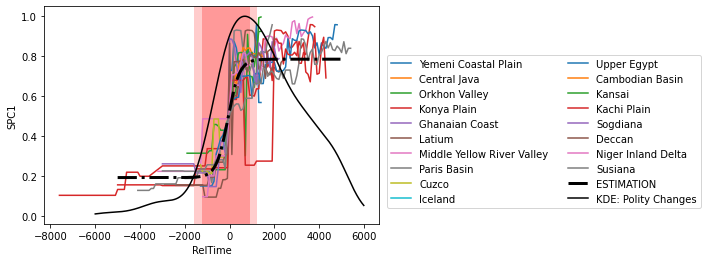

In [21]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

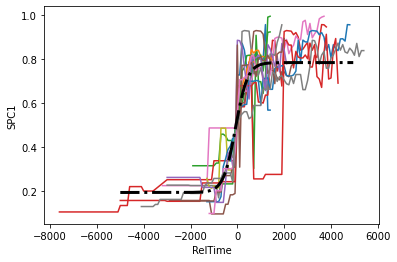

In [22]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
#plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
#plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
#plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
#plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

#plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.savefig("FullLogistic.pdf", dpi=200, bbox_inches="tight")
plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [23]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [24]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [25]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

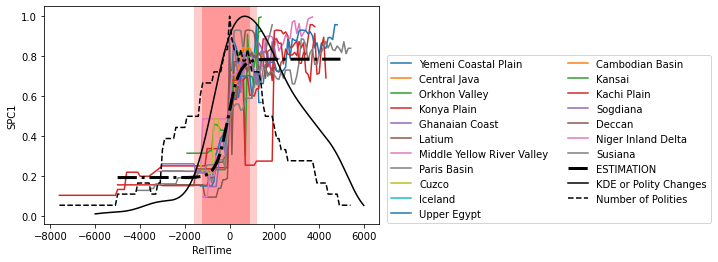

In [26]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [27]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [28]:
print(Relationships[["NGA", "Polity.Start.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.Start.Scaled
580     Sogdiana               -250.0
587     Sogdiana                371.0
593     Sogdiana                908.0
606     Sogdiana               1450.0
699      Susiana               1430.0
708      Susiana               2200.0
710      Susiana               2301.0
713      Susiana               2501.0
726      Susiana               3453.0
744      Susiana               4632.0
745      Susiana               4632.0
746      Susiana               4737.0
747      Susiana               4737.0
754      Susiana               4956.0
756      Susiana               4956.0
757      Susiana               5039.0
764      Susiana               5201.0
765      Susiana               5494.0
784  Upper Egypt               2031.0
788  Upper Egypt               2436.0


In [29]:
Breakpoints = Relationships[["NGA", "Polity.Start.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,492.0
138,Cuzco,-900.0
142,Cuzco,-750.0
145,Cuzco,-400.0
149,Cuzco,-25.0


In [65]:
for t in Breakpoints[Breakpoints.NGA=="Latium"].RelTime:
    print(t)

669.0
1411.0


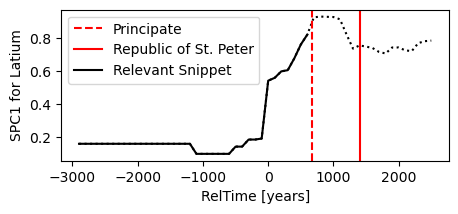

In [87]:
plt.figure(figsize =(5,2), dpi=100)
DF = RelTimeDF[RelTimeDF["NGA"]=="Latium"] # no reltime
plt.plot(DF["RelTime"], DF["SPC1"], c="k", linestyle =":")

L = "Principate"
colour ="red"
style="--"
for t in Breakpoints[Breakpoints.NGA=="Latium"].RelTime:
    plt.axvline(t,label=L,
                c = colour,
                linestyle = style )
    L = "Republic of St. Peter"
    style = "-"

UpTo = Breakpoints[Breakpoints.NGA=="Latium"].RelTime.iloc[0]

DF = DF.query("RelTime<@UpTo")

plt.plot(DF["RelTime"], DF["SPC1"], c="k", linestyle="-",label="Relevant Snippet")

    
    
    
plt.legend()
plt.xlabel("RelTime [years]")
plt.ylabel("SPC1 for Latium")

plt.savefig("Latium_Discontinuities.pdf",dpi=200, bbox_inches='tight')
plt.show()

In [86]:
Breakpoints[Breakpoints.NGA=="Latium"].RelTime.iloc[0]

669.0

In [30]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [31]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs                       NGA  RelTime
862  Yemeni Coastal Plain   1473.0
-inf 1473.0
                      NGA  RelTime      SPC1
413  Yemeni Coastal Plain        0  0.729010
414  Yemeni Coastal Plain      100  0.729010
415  Yemeni Coastal Plain      200  0.874002
416  Yemeni Coastal Plain      300  0.841906
417  Yemeni Coastal Plain      500  0.686559
418  Yemeni Coastal Plain      600  0.686559
419  Yemeni Coastal Plain      700  0.802861
420  Yemeni Coastal Plain      800  0.839822
421  Yemeni Coastal Plain      900  0.801720
422  Yemeni Coastal Plain     1000  0.801720
423  Yemeni Coastal Plain     1100  0.797062
424  Yemeni Coastal Plain     1200  0.958307
425  Yemeni Coastal Plain     1300  0.568928
426  Yemeni Coastal Plain     1400  0.568928
BPs                       NGA  RelTime
862  Yemeni Coastal Plain   1473.0
-inf 1473.0
BPs                       NGA  RelTime
862  Yemeni Coastal Plain   1473.0
-inf 1473.0
BPs              NGA  RelTime
67  Central Java    492.0
-inf 492.0


181  Cambodian Basin     1500  0.797299
BPs         NGA  RelTime
263  Kansai   -700.0
-700.0 inf
        NGA  RelTime      SPC1
182  Kansai     -700  0.232953
183  Kansai     -600  0.232953
184  Kansai     -500  0.232953
185  Kansai     -400  0.232953
186  Kansai     -300  0.232953
187  Kansai     -200  0.232953
188  Kansai     -100  0.474899
189  Kansai        0  0.534591
190  Kansai      100  0.581717
191  Kansai      200  0.746241
192  Kansai      300  0.763181
193  Kansai      400  0.816839
194  Kansai      500  0.818973
195  Kansai      600  0.816803
196  Kansai      700  0.818791
197  Kansai      800  0.803606
198  Kansai      900  0.802764
199  Kansai     1000  0.819800
200  Kansai     1100  0.746661
201  Kansai     1200  0.824980
202  Kansai     1300  0.923083
203  Kansai     1400  0.924962
BPs         NGA  RelTime
263  Kansai   -700.0
-700.0 inf
BPs         NGA  RelTime
263  Kansai   -700.0
-700.0 inf
BPs              NGA  RelTime
212  Kachi Plain  -5000.0
216  Kachi Plain  -1

In [32]:
Cutout_DF, Cutout_CCDF


(                      NGA RelTime      SPC1
 413  Yemeni Coastal Plain       0  0.729010
 414  Yemeni Coastal Plain     100  0.729010
 415  Yemeni Coastal Plain     200  0.874002
 416  Yemeni Coastal Plain     300  0.841906
 417  Yemeni Coastal Plain     500  0.686559
 ..                    ...     ...       ...
 51                Susiana    1000  0.589980
 52                Susiana    1100  0.664407
 53                Susiana    1200  0.664407
 54                Susiana    1300  0.664407
 55                Susiana    1400  0.664407
 
 [368 rows x 3 columns],
                       NGA RelTime      SPC1    PolPop   PolTerr    CapPop  \
 574  Yemeni Coastal Plain       0  0.729010  5.546353  5.415713  4.045449   
 575  Yemeni Coastal Plain     100  0.729010  5.546353  5.415713  4.045449   
 576  Yemeni Coastal Plain     200  0.874002  7.344392  6.414973  5.698970   
 577  Yemeni Coastal Plain     300  0.841906  7.391732  6.954243  5.479298   
 578  Yemeni Coastal Plain     500  0.68655

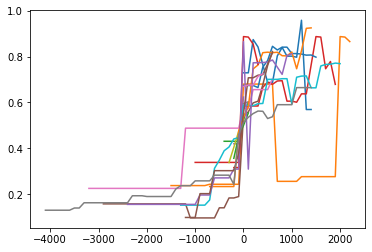

In [33]:
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

### Dan's Questions

Do large NGAs reach the SPC1 threshold again after a decline?

In [34]:
DF_Second = Cutout_DF.loc[Cutout_DF["RelTime"]>-1]
DF_Second.loc[DF_Second["SPC1"]< 0.49] # this is the SPC_Break from the other notebook

,NGA,RelTime,SPC1
261,Kachi Plain,700,0.255631
262,Kachi Plain,800,0.255631
263,Kachi Plain,900,0.255631
264,Kachi Plain,1000,0.255631
265,Kachi Plain,1100,0.255631
266,Kachi Plain,1200,0.276092
267,Kachi Plain,1300,0.276092
268,Kachi Plain,1400,0.276092
269,Kachi Plain,1500,0.276092
270,Kachi Plain,1600,0.276092


So indeed, the Orkhon Valley experiences a decline in SPC1 below the threshold after a discontinuous polity change!

In [35]:
# analyse this further
RelTimeDF.loc[RelTimeDF["NGA"] == "Orkhon Valley"]

,NGA,RelTime,SPC1
485,Orkhon Valley,-1900,0.315541
486,Orkhon Valley,-1800,0.315541
487,Orkhon Valley,-1700,0.315541
488,Orkhon Valley,-1600,0.315541
489,Orkhon Valley,-1500,0.315541
490,Orkhon Valley,-1400,0.315541
491,Orkhon Valley,-1300,0.315541
492,Orkhon Valley,-1200,0.315541
493,Orkhon Valley,-1100,0.315541
494,Orkhon Valley,-1000,0.315541


# Redo the RelTime Analysis with this Data?

## Fitting

In [36]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 4.76748566e-01  2.11587418e-01  4.39930349e+01 -2.25088971e-02]


In [37]:
# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749265e+01, -1.54321380e-02])

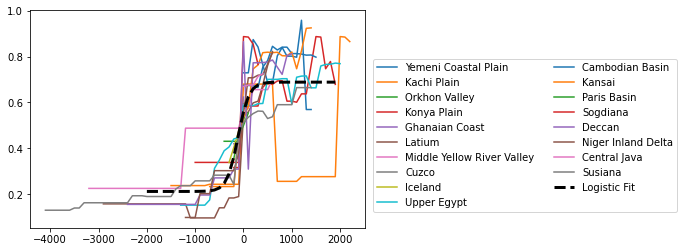

In [38]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [39]:
L = len(Cutout_DF["RelTime"].to_numpy())
def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [40]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    

C:\Users\Tobias\AppData\Local\Temp/ipykernel_8316/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [41]:
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

0.7386798988199759 0.7418772784786102 0.032533275459181714


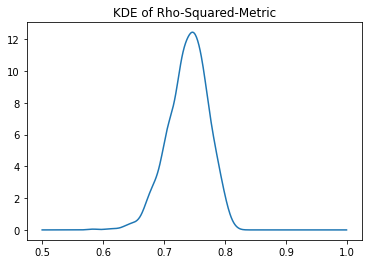

In [42]:
plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [43]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.4646357110775954 0.23640146796417147 55.48799229402803 -0.019309840870420075
-----------------
0.43816612259624016 0.2302419070955047 46.04185692015254 -0.027049725784745998
-----------------
0.5525231032613089 0.20006857595874672 26.627389963695006 -0.02982409270380491
-----------------
0.5597661641166247 0.2005725130297083 18.740723393536378 -0.023833290449928518
-----------------
0.5903521612977332 0.18673268498777465 23.43964456081845 -0.014225548772137704
-----------------
0.41414432668180867 0.1910088599400263 76.7663142934884 -0.024155557550612404
-----------------
0.49309773063892953 0.19927905021158387 27.889472504806154 -0.0264958632797566
-----------------
0.43833282653672867 0.2537897999045554 95.3606057698816 -0.014216853641856377
-----------------
0.43764707645267276 0.2211398964633932 30.301625660438475 -0.03369856671533615
-----------------
0.4762203797631209 0.2085181808054351 55.69364532757155 -0.019680003850780014
-----------------
0.43120335135044724 0.23149392353

0.5460598729730082 0.2403251997275192 19.787450072135115 -0.009369801544459946
-----------------
0.4689160515667852 0.19791312706958109 172.21845719604772 -0.015576144261507675
-----------------
0.4292885670947331 0.20947817721936138 37.41702318309464 -0.029042914938798545
-----------------
0.4515160536574545 0.18758742864237127 25.764831909008226 -0.04150618993347007
-----------------
0.4593844240712201 0.21136828197780014 48.172346598349904 -0.023433793411276223
-----------------
0.4786596198563263 0.20276444564592574 31.441481011097437 -0.032007298777293844
-----------------
0.5307593710551479 0.17679118784778103 67.81730190028433 -0.015907509169467284
-----------------
0.4692910283036371 0.19830728712166695 51.426062891137086 -0.02303700765856493
-----------------
0.5421479645494766 0.20514536146634757 25.32302403103499 -0.023629860149497934
-----------------
0.39979018462266663 0.23463768835410231 71.4323834406231 -0.021693884698923614
-----------------
0.45002027111842524 0.21774

0.44485746033169393 0.18733623036703861 40.52296471031259 -0.02568712692510186
-----------------
0.6145897599532094 0.159754533256002 33.26686425494092 -0.018046064973381095
-----------------
0.5286589689815144 0.17961229401582035 52.28301830657817 -0.022675075623970625
-----------------
0.49534655559442275 0.23151121618806678 82.73852725329179 -0.014778425420478528
-----------------
0.5428292389572515 0.21740560688715013 30.007345625502303 -0.015156037266019681
-----------------
0.5601117912892574 0.17155658861738526 53.13425529812675 -0.01666842378545506
-----------------
0.5580500147413158 0.16737583909800124 24.66015429006222 -0.020800478335265545
-----------------
0.4214690020618546 0.24686861996901294 74.99687386240991 -0.019175144474626708
-----------------
0.43011656043777874 0.22893411439537675 88.11167210725057 -0.018090859846565034
-----------------
0.5438338300433478 0.18873039098418756 50.52565139436537 -0.021222542838479255
-----------------
0.4473378703298863 0.231076946

-----------------
0.5039129553198269 0.2016476886251184 81.31957443490104 -0.01830394124975792
-----------------
0.3734462556729357 0.2537772825751114 935.6183287850272 -0.018817998100896023
-----------------
0.44535585158530555 0.2800585828266397 103.35656393455993 -0.012694657878543333
-----------------
0.4366255330766822 0.220912726079145 60.22426706175477 -0.022590094143852477
-----------------
0.532547863485297 0.19171773691955726 49.83919480090546 -0.015903767005051972
-----------------
0.46686445534062965 0.20286132690743014 78.14667756646348 -0.01867903828427124
-----------------
0.43289334519979716 0.22049305126281268 39.69908080955584 -0.025062869308763197
-----------------
0.5246982987685909 0.18313239262536435 45.15452295529295 -0.021169443900686414
-----------------
0.3721346975748898 0.2450114908374204 52.9914363973634 -0.02648328533058677
-----------------
0.5164338877615962 0.1722429598504361 31.137362877898074 -0.024979377427031005
-----------------
0.5239616860685842 

C:\Users\Tobias\AppData\Local\Temp/ipykernel_8316/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.4108834102917274 0.20375881955303246 888.1875796869763 -0.01927023810332322
-----------------
0.5555826561450425 0.19859844604154048 37.357027268297294 -0.01833519719684345
-----------------
0.5532277688111732 0.1734482953515871 54.338445813351605 -0.0172569643577717
-----------------
0.4782015527437772 0.22460694719995578 58.7500215203434 -0.018738486229250558
-----------------
0.58245110949901 0.17820368291307012 27.889446291678738 -0.021329879260334784
-----------------
0.45776526804065126 0.24320876175220388 44.42012664150752 -0.016782258947566544
-----------------
0.3693982593636828 0.22513365377285866 979.8722965330234 -0.019469578858104793
-----------------
0.5281935648980872 0.18218429065012687 34.77855174953618 -0.024076420696621383
-----------------
0.4563016079776744 0.2162991613821664 108.58419489297063 -0.01780711044507559
-----------------
0.4062183047670757 0.20380177578097056 75.15953455926422 -0.024403467124246486
-----------------
0.45296280468447186 0.1943170453056

0.5417691874207449 0.17907800334011517 31.389084526113177 -0.030344669768583285
-----------------
0.4029039448007967 0.26718929778963324 57.56946473474604 -0.01794279990425539
-----------------
0.5044495099551437 0.19422401060795882 41.76114942720641 -0.021926081964968546
-----------------
0.5566316908963281 0.1749814069490999 27.03243165437864 -0.026310081870334626
-----------------
0.5184493495394716 0.18445979365168091 36.40083511126335 -0.019329629956241042
-----------------
0.5291413195442711 0.1800312874204399 19.612285733172712 -0.02543192289039639
-----------------
0.5704929762311961 0.19062662808651157 22.33855567534163 -0.024961012318491443
-----------------
0.5549906005112321 0.1757827868501306 44.68692362206338 -0.015425700931686525
-----------------
0.533589642059391 0.20659368301812853 50.7967459317909 -0.016948390709996725
-----------------
0.5350646554324616 0.21747229008919233 24.831478544384336 -0.01878365878053495
-----------------
0.4820880490971237 0.21978477587906

0.4576417891949392 0.23312035735216302 31.71884324264622 -0.02782587191486094
-----------------
0.4661462999754302 0.20027867340507313 41.95296766023892 -0.020045591904594526
-----------------
0.46919346636966813 0.20239312447195584 50.296207825808 -0.023147796026103153
-----------------
0.42205671857526 0.2365130358459375 41.48359853120094 -0.03560687492377069
-----------------
0.47020690842869833 0.2219080930327414 84.08201207078194 -0.017283587025895494
-----------------
0.5583529680323077 0.20024587177381423 28.265839704480157 -0.02148460710978163
-----------------
0.28897075720098236 0.2912919603940345 58.43454608939525 -0.035600890046418136
-----------------
0.49146747922500056 0.18772952217508945 32.123710417495865 -0.02962829623596379
-----------------
0.35818799336070284 0.26324789438312524 67.19260846639877 -0.022681983883564405
-----------------
0.5026733988910317 0.2023521376175613 56.9549389902282 -0.018140907621190517
-----------------
0.5040699606934788 0.189890735939546

0.522653989752137 0.18645104611713148 28.192696137424935 -0.027920008694764506
-----------------
0.5502592960436355 0.1784770133400356 30.87551612222489 -0.014396100616726401
-----------------
0.5561110752977413 0.20471022288553103 34.520685772216204 -0.015226853811762706
-----------------
0.5654155930478086 0.18087821115453306 48.33001772336642 -0.018192392109616436
-----------------
0.4119636105560537 0.27204947092133724 60.10815380238031 -0.016442294548546208
-----------------
0.452105940034448 0.20491672472527755 44.152614092092996 -0.026286998922395294
-----------------
0.4928580338989168 0.20397987838177106 39.59312215256257 -0.01785854304230047
-----------------
0.5843784505719704 0.18556022546133552 26.39582077402411 -0.017777672158120168
-----------------
0.4053265916543307 0.22378161143004466 55.34395382502375 -0.023926344871598636
-----------------
0.5604572682336477 0.19128155510140837 29.26417078163166 -0.0220247361463737
-----------------
0.3999587324888827 0.214083537718

0.4927681018908885 0.19865312509213987 30.82544035006567 -0.030429580990468334
-----------------
0.5701544625525425 0.21433109003335338 14.983346661875059 -0.03673836281976745
-----------------
0.529368891142915 0.18870300470590554 27.184831595431774 -0.025302953323237867
-----------------
0.3955054592552227 0.21436145742278226 386.2847411638205 -0.01773781206151618
-----------------
0.5100051516402158 0.184235876512328 49.819281079790855 -0.02171545666969064
-----------------
0.44559126607778926 0.2028733155828813 49.9306153916171 -0.030575687153328493
-----------------
0.44653341123713913 0.2419354342265479 242.35116713665704 -0.016251880088553536
-----------------
0.44357579196717983 0.1982253751517343 37.13519877697417 -0.0256648321904817
-----------------
0.5008508335749882 0.18084862965284837 41.57265871343651 -0.02129393104724639
-----------------
0.4845795000782339 0.2276922255416726 53.696888311532646 -0.016856060666896454
-----------------
0.45897091722523237 0.23682070191137

0.3793766428458164 0.21834605010749453 120.48751257293527 -0.019762812618036394
-----------------
0.44576367756664664 0.22866337358777844 262.9582367442307 -0.017224309117625236
-----------------
0.42977184631519233 0.23853778046789662 49.14032682414526 -0.02501870643678106
-----------------
0.4113849143178799 0.19353102078623605 95.2043052637497 -0.022013117874384373
-----------------
0.40384670852900617 0.23804631349120944 46.55596238520651 -0.02432177381323817
-----------------
0.4693601596751574 0.2205459295385321 40.81342401497475 -0.01832998719369043
-----------------
0.5586386071344297 0.18626678645707928 29.202034567869347 -0.016070469664701437
-----------------
0.4909820523977097 0.22048305848663946 52.43131448494247 -0.02151822578385238
-----------------
0.4479764765574687 0.22082523417861627 33.59091456007697 -0.03289570800653448
-----------------
0.5395712000996051 0.18890261899016408 14.554530296667457 -0.03331958265913445
-----------------
0.48954567279510647 0.2056983802

0.5732479031174471 0.18969873493721706 31.252713920966976 -0.014149514464339569
-----------------
0.41606600014689726 0.22791022287098828 869.6876810878215 -0.01897577417908794
-----------------
0.48310389751735827 0.18607316441532964 107.63414817530574 -0.01609272859617427
-----------------
0.4870921850193314 0.20889706486345833 50.29283851597846 -0.024693891918348962
-----------------
0.4249804389644769 0.28079857232355104 81.88498941746357 -0.01253973398982372
-----------------
0.4533949516445957 0.22493451666970443 184.43942276765634 -0.01597976051372309
-----------------
0.4612097564738445 0.238109014239087 55.03886466280377 -0.016711231596408287
-----------------
0.4814010230019409 0.20066250373612274 28.592301747199034 -0.030559724280708814
-----------------
0.48489768880875495 0.20476061651510233 52.22285328049016 -0.01766316430780367
-----------------
0.5053690942467954 0.18289669185917207 29.092860349627735 -0.03966211722224188
-----------------
0.5291026081627636 0.219485757

-----------------
0.5184616725729947 0.18643095344539348 40.65288341391524 -0.022332253313239656
-----------------
0.5507577113906424 0.19431005683596053 23.298959959965945 -0.021282460066815688
-----------------
0.467322400958228 0.20200069597134968 28.87578928969579 -0.03157979753810993
-----------------
0.40082607139498294 0.1985551077396504 63.323981370223045 -0.024729838274559865
-----------------
0.4853296902510787 0.2026372027791091 55.12697804894729 -0.023459803020703333
-----------------
0.5475788990225351 0.1821456559221156 16.713550904945013 -0.031027044571796673
-----------------
0.4362268164469858 0.24222039863398134 275.2588085537919 -0.015315176278642258
-----------------
0.5006992557921848 0.20350342334255267 56.87667415047096 -0.01869581266630316
-----------------
0.6210011146317381 0.1627416890609178 31.415825068558462 -0.012450941379223845
-----------------
0.46419168787907317 0.19868176259237832 40.6804856937433 -0.026291606378593672
-----------------
0.415980760326

In [44]:
print(negCcount)

0


In [45]:
Params

,a,b,c,d
0,0.464636,0.236401,55.487992,-0.019310
0,0.438166,0.230242,46.041857,-0.027050
0,0.552523,0.200069,26.627390,-0.029824
0,0.559766,0.200573,18.740723,-0.023833
0,0.590352,0.186733,23.439645,-0.014226
...,...,...,...,...
0,0.416709,0.215587,45.737393,-0.024713
0,0.468582,0.232359,49.789269,-0.018561
0,0.425786,0.227994,55.015803,-0.021767
0,0.484032,0.250565,85.829741,-0.013853


Mean 0.4899511247314257  and Median 0.4863588199483767
50% centred quantiles 0.4475460545170686 0.5413733748122079
90% centred quantiles 0.3916778836662953 0.5817065401031943


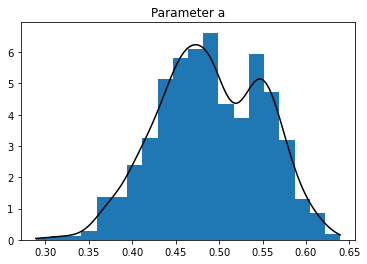

Mean 0.20757207050682752  and Median 0.20481434260012762
50% centred quantiles 0.18862012228577613 0.22265009864436502
90% centred quantiles 0.17197420062361532 0.2522983233333391


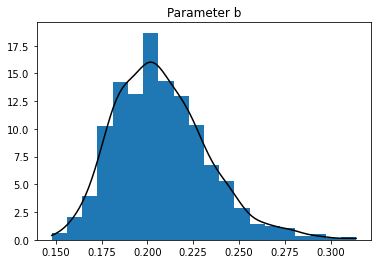

Mean 75.90544909118529  and Median 40.746954854359025
50% centred quantiles 28.989096383179156 58.6636074647197
90% centred quantiles 19.787277981793245 192.91227342742417


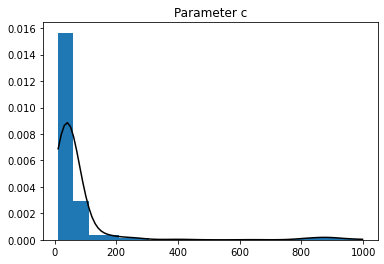

Mean -0.022279023143024178  and Median -0.02088847355606007
50% centred quantiles -0.02517489666824055 -0.017816451641406
90% centred quantiles -0.03463769457278666 -0.01434497542841903


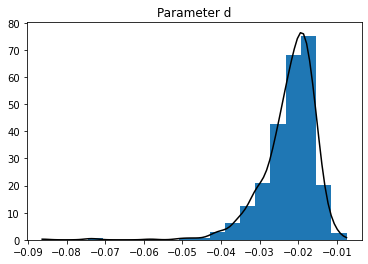

In [46]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    print("Mean", np.mean(Ps), " and Median", np.median(Ps))
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [47]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(28.989096383179156, 58.6636074647197)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


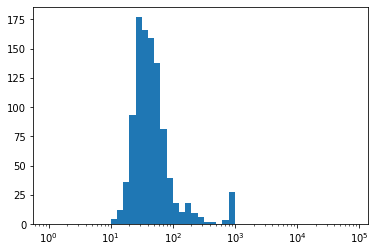

In [48]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [49]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20757207050682752 0.025432888271167582
0.6975231952382536 0.0462448931412063
0.2330049587779951 0.6512783020970473


C:\Users\Tobias\AppData\Local\Temp/ipykernel_8316/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [50]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  629.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [51]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [52]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.43816612259624016 0.2302419070955047 46.04185692015254 -0.027049725784745998     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.81638601e-12])
       r: array([-0.12641404])
  status: 1
 success: True
       x: array([-0.13694834])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.23228119e-12])
       r: array([-0.75785212])
  status: 1
 success: True
       x: array([0.0424936])
-----------------
0.5525231032613089 0.20006857595874672 26.627389963695006 -0.02982409270380491     fjac: array([[-1.]])
     fun: array([4.16333634e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.17450244e-10])
       r: array([-0.82473362])
  status: 1
 success: True
       x: array([-0.13341877])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.38215061e-11])
       r: array(

0.512443837348586 0.19570764135024132 19.804230356265535 -0.031045890417224005     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.14352972e-14])
       r: array([-0.68488374])
  status: 1
 success: True
       x: array([-0.15953873])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([4.6629367e-14])
       r: array([-1.00132468])
  status: 1
 success: True
       x: array([0.07401889])
-----------------
0.4650557275053697 0.197300420256726 29.048826014268833 -0.03177069472800106     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.27553565e-14])
       r: array([-0.95754612])
  status: 1
 success: True
       x: array([-0.11738508])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([7.21644966e-15])
       r: array([

C:\Users\Tobias\AppData\Local\Temp/ipykernel_8316/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5651301713725373 0.1651077739157494 24.76571203203621 -0.015934161582012944     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-9.96619454e-13])
       r: array([-1.47949693])
  status: 1
 success: True
       x: array([-0.09633016])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.51947368e-11])
       r: array([-1.68227369])
  status: 1
 success: True
       x: array([0.05745854])
-----------------
0.5470591181846711 0.2092823514971765 30.82625463796612 -0.016160325875292036     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.06757961e-13])
       r: array([-0.69956813])
  status: 1
 success: True
       x: array([-0.1165227])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.94764213e-13])
       r: array([-

0.45790864953019433 0.2112520576579163 43.22932112948382 -0.02658452710081759     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-4.47956672e-11])
       r: array([-0.89569339])
  status: 1
 success: True
       x: array([-0.09594144])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.44009282e-15])
       r: array([-0.74285485])
  status: 1
 success: True
       x: array([0.0475091])
-----------------
0.5347184996737057 0.1875445933604748 22.55911735498795 -0.03393294775042966     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.94762539e-11])
       r: array([-0.93835742])
  status: 1
 success: True
       x: array([-0.13925841])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.4899193e-13])
       r: array([-1.3

0.5287920581383879 0.18795613348061813 41.12870849708387 -0.022407029402263995     fjac: array([[-1.]])
     fun: array([-1.77635684e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.03071096e-10])
       r: array([-1.69496612])
  status: 1
 success: True
       x: array([-0.08012358])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.47537538e-12])
       r: array([-2.35930946])
  status: 1
 success: True
       x: array([0.02517123])
-----------------
0.5402273639307787 0.19366388325376047 23.883075825184665 -0.02527699153841395     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.06623085e-12])
       r: array([-0.87116271])
  status: 1
 success: True
       x: array([-0.13180054])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.40998324e-14])
       r: arra

0.4458687121599265 0.22381382490709997 63.395498074507486 -0.022095303077628     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.80466753e-13])
       r: array([-0.57066514])
  status: 1
 success: True
       x: array([-0.08299798])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.93965954e-11])
       r: array([-1.11858771])
  status: 1
 success: True
       x: array([0.02751848])
-----------------
0.5215550669840949 0.18359488707341645 44.904983480088084 -0.023897946533831572     fjac: array([[-1.]])
     fun: array([2.77555756e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.05636666e-10])
       r: array([-2.00855679])
  status: 1
 success: True
       x: array([-0.07416256])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.24534843e-11])
    

0.6043622780065118 0.1747918044777686 33.765633686948036 -0.013738693190629637     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.00883199e-11])
       r: array([-1.7762755])
  status: 1
 success: True
       x: array([-0.08004222])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.21565038e-15])
       r: array([-3.40421102])
  status: 1
 success: True
       x: array([0.02521749])
-----------------
0.5063532252492116 0.18094295161976526 32.13524421799696 -0.02596739397275732     fjac: array([[-1.]])
     fun: array([9.99200722e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.94716937e-10])
       r: array([-1.50101701])
  status: 1
 success: True
       x: array([-0.09337945])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.76996262e-15])
       r: array([

0.5503978035970094 0.18389927760782754 29.83896738626181 -0.024630392305298406     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.20625732e-13])
       r: array([-1.33453428])
  status: 1
 success: True
       x: array([-0.10248879])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-3.92796906e-13])
       r: array([-2.10354893])
  status: 1
 success: True
       x: array([0.03328293])
-----------------
0.4657485264614018 0.21065074991371144 27.320243892328634 -0.031386389533361946     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-8.79296636e-14])
       r: array([-0.58141006])
  status: 1
 success: True
       x: array([-0.14073552])     fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.87545601e-11])


0.5601117912892574 0.17155658861738526 53.13425529812675 -0.01666842378545506     fjac: array([[-1.]])
     fun: array([-6.21724894e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-7.40268624e-10])
       r: array([-2.90679313])
  status: 1
 success: True
       x: array([-0.05607302])     fjac: array([[-1.]])
     fun: array([-6.66133815e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.1473523e-10])
       r: array([-3.65839394])
  status: 1
 success: True
       x: array([0.01695048])
-----------------
0.5580500147413158 0.16737583909800124 24.66015429006222 -0.020800478335265545     fjac: array([[-1.]])
     fun: array([6.41153797e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-8.91139829e-10])
       r: array([-1.42810072])
  status: 1
 success: True
       x: array([-0.10252399])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.8404

0.4731302041947638 0.19964433263903142 32.412685409715486 -0.031961480390901006     fjac: array([[-1.]])
     fun: array([5.66213743e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.55683444e-10])
       r: array([-1.00507422])
  status: 1
 success: True
       x: array([-0.11152522])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([8.82660611e-12])
       r: array([-0.66509512])
  status: 1
 success: True
       x: array([0.06198304])
-----------------
0.5002178200324128 0.1787175431241868 33.12567491682116 -0.020461999256283385     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.72479825e-14])
       r: array([-1.60314144])
  status: 1
 success: True
       x: array([-0.08403415])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.37465628e-11])
    

0.5604018358288961 0.17648385494881086 28.554946319693904 -0.01906191118397676     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.02748365e-12])
       r: array([-1.45117649])
  status: 1
 success: True
       x: array([-0.0956765])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.47074641e-11])
       r: array([-2.0710916])
  status: 1
 success: True
       x: array([0.04093156])
-----------------
0.575428523138903 0.19231735086266863 27.777408883492985 -0.015684941811265566     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.59868507e-11])
       r: array([-1.05028306])
  status: 1
 success: True
       x: array([-0.10841709])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-6.75703937e-12])
   

0.4654518008646912 0.21582249855997937 29.47040734208738 -0.031154807286043792     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.95732319e-12])
       r: array([-0.48768119])
  status: 1
 success: True
       x: array([-0.14182532])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.93067784e-13])
       r: array([-0.82702539])
  status: 1
 success: True
       x: array([0.05962539])
-----------------
0.435193795163142 0.21974366076806295 35.73406870759698 -0.032123731252784456     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.45164999e-13])
       r: array([-0.45944005])
  status: 1
 success: True
       x: array([-0.12894997])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([4.99600361e-15])
       r: arr

0.5239616860685842 0.20959745190556944 32.09741562788074 -0.025915913930949493     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.58541791e-11])
       r: array([-0.71775688])
  status: 1
 success: True
       x: array([-0.12133354])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.33146835e-15])
       r: array([-2.22627001])
  status: 1
 success: True
       x: array([0.02643875])
-----------------
0.502487074256105 0.18428882514341988 50.630474442034924 -0.021189141746763483     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.4849233e-14])
       r: array([-2.22739174])
  status: 1
 success: True
       x: array([-0.06526501])     fjac: array([[-1.]])
     fun: array([2.10942375e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.48749141e-10])
       r: array(

0.5162086024005855 0.1738547374092717 25.552265406062222 -0.026799912753795656     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.9741101e-13])
       r: array([-1.33823464])
  status: 1
 success: True
       x: array([-0.10682142])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([6.4853678e-12])
       r: array([-0.91658444])
  status: 1
 success: True
       x: array([0.07144459])
-----------------
0.5621741152984361 0.1829011921963299 26.49229106691907 -0.014813507591098765     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.12805337e-14])
       r: array([-1.20906232])
  status: 1
 success: True
       x: array([-0.10255095])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.93178806e-14])
       r: array([-2

0.5370903603030529 0.18677247764161622 32.329137002029604 -0.018253914853744595     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([5.75084425e-12])
       r: array([-1.36599596])
  status: 1
 success: True
       x: array([-0.09132954])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.56812357e-11])
       r: array([-2.02946893])
  status: 1
 success: True
       x: array([0.03916247])
-----------------
0.5704125417417037 0.2027763016054938 24.991582280691752 -0.01718878313505928     fjac: array([[-1.]])
     fun: array([8.32667268e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.23019952e-11])
       r: array([-0.71542822])
  status: 1
 success: True
       x: array([-0.1325524])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.59402491e-11])
       r: array([-2.39557962])

0.5044532097658394 0.17436030432044547 32.88404368015117 -0.031915759445523065     fjac: array([[-1.]])
     fun: array([3.49720253e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-4.35756542e-10])
       r: array([-1.70429453])
  status: 1
 success: True
       x: array([-0.09359896])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.6510352e-14])
       r: array([-0.85604477])
  status: 1
 success: True
       x: array([0.05480955])
-----------------
0.5728492458762373 0.16242704900629468 29.018702544802295 -0.018527563636143354     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-6.05944739e-11])
       r: array([-1.7957434])
  status: 1
 success: True
       x: array([-0.08615372])     fjac: array([[-1.]])
     fun: array([-1.33226763e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.96010891e-10])
   

0.451332195170981 0.20459431592788793 45.71508590983679 -0.027107152980489546     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.0185858e-14])
       r: array([-1.21703795])
  status: 1
 success: True
       x: array([-0.08617787])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.93178806e-14])
       r: array([-0.21030486])
  status: 1
 success: True
       x: array([0.07275855])
-----------------
0.5004384826348338 0.1848734686969876 56.629635089623804 -0.01934358657671985     fjac: array([[-1.]])
     fun: array([7.21644966e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.86260646e-10])
       r: array([-2.4635082])
  status: 1
 success: True
       x: array([-0.05890634])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.44882994e-11])
       r: array([-1.796243])
  

0.5713295494672604 0.206731667274587 21.72430301243726 -0.013978254094309098     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.4058199e-13])
       r: array([-0.54452147])
  status: 1
 success: True
       x: array([-0.15356092])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.77393672e-11])
       r: array([-2.14307553])
  status: 1
 success: True
       x: array([0.04377175])
-----------------
0.537503996055207 0.19168267925300125 27.55631490180577 -0.020417198296391846     fjac: array([[-1.]])
     fun: array([8.32667268e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.18753096e-11])
       r: array([-1.05115162])
  status: 1
 success: True
       x: array([-0.11061578])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.99360578e-15])
      

0.551916133175171 0.20212428939246108 17.2859505534737 -0.021316161501567774     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.89213098e-12])
       r: array([-0.50393479])
  status: 1
 success: True
       x: array([-0.18478346])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.21256347e-12])
       r: array([-1.44560148])
  status: 1
 success: True
       x: array([0.0640103])
-----------------
0.5846912893000684 0.17483508865364186 26.23375688203914 -0.02247561361464202     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.00255915e-12])
       r: array([-1.37419406])
  status: 1
 success: True
       x: array([-0.10644851])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([2.39808173e-14])
       r: array([-2.31400986])


-----------------
0.4956428625314921 0.20501101398450677 23.61111847343164 -0.02943128291159031     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-5.13200593e-14])
       r: array([-0.62363683])
  status: 1
 success: True
       x: array([-0.14868568])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.17683641e-14])
       r: array([-1.0496751])
  status: 1
 success: True
       x: array([0.06380709])
-----------------
0.48883344987809735 0.20444058392454104 42.88160101074259 -0.020582255930169508     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.08860707e-13])
       r: array([-1.15331153])
  status: 1
 success: True
       x: array([-0.08540379])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([6.70958844e-11])
       r: 

0.5414087291467372 0.2031842688036776 17.817277323413425 -0.03301790447890687     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.55003796e-11])
       r: array([-0.5020591])
  status: 1
 success: True
       x: array([-0.19254381])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.03916875e-13])
       r: array([-1.37605346])
  status: 1
 success: True
       x: array([0.05504412])
-----------------
0.48810093641337826 0.21291539898957335 56.738166569797805 -0.01799320023417528     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([6.59194921e-14])
       r: array([-1.09293031])
  status: 1
 success: True
       x: array([-0.07348129])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.15633067e-11])
       r: array([-2.5344728

0.5015524929537645 0.19737362928483212 44.84930751734959 -0.017692040793285502     fjac: array([[-1.]])
     fun: array([1.66533454e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([6.65950073e-11])
       r: array([-1.48450872])
  status: 1
 success: True
       x: array([-0.07501268])     fjac: array([[-1.]])
     fun: array([-4.21884749e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-4.49877802e-10])
       r: array([-1.93393971])
  status: 1
 success: True
       x: array([0.03256627])
-----------------
0.570014105564877 0.15989319382671266 26.141481734516248 -0.017374157370087902     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([5.95170024e-11])
       r: array([-1.66610356])
  status: 1
 success: True
       x: array([-0.09068309])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.55240315e-12])
    

0.503596320149941 0.20539413373829982 49.021526998503916 -0.018613954872582803     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.1122247e-11])
       r: array([-1.27931084])
  status: 1
 success: True
       x: array([-0.07669414])     fjac: array([[-1.]])
     fun: array([2.44249065e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.20185442e-10])
       r: array([-2.5049333])
  status: 1
 success: True
       x: array([0.02309408])
-----------------
0.4417154822493714 0.2298166614832054 49.38567133429527 -0.02631063873143182     fjac: array([[-1.]])
     fun: array([2.69229083e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.43372203e-10])
       r: array([-0.15632263])
  status: 1
 success: True
       x: array([-0.12601435])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.38538095e-14])
       

0.540272277742758 0.17757653083703961 47.6818847512062 -0.01939808684893721     fjac: array([[-1.]])
     fun: array([-2.77555756e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.01590736e-10])
       r: array([-2.371778])
  status: 1
 success: True
       x: array([-0.06488149])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.52100554e-14])
       r: array([-2.78309203])
  status: 1
 success: True
       x: array([0.02175625])
-----------------
0.5506651893060607 0.18561077200923015 33.07369401852396 -0.01997637835533929     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([3.40449891e-12])
       r: array([-1.43258976])
  status: 1
 success: True
       x: array([-0.09141168])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.918288e-14])
       r: array([-2.37

0.4460651559593709 0.21151093981155858 24.969953066683686 -0.04100424783920334     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.74764925e-11])
       r: array([-0.51084387])
  status: 1
 success: True
       x: array([-0.16048004])     fjac: array([[-1.]])
     fun: array([-6.66133815e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([8.02583555e-11])
       r: array([-0.15503671])
  status: 1
 success: True
       x: array([0.12904199])
-----------------
0.47988078455199784 0.22570099637677377 30.175064986181898 -0.02504516477717146     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-4.50245397e-12])
       r: array([-0.21704329])
  status: 1
 success: True
       x: array([-0.16323156])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.96509475e-14])

0.5604572682336477 0.19128155510140837 29.26417078163166 -0.0220247361463737     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.20017615e-11])
       r: array([-1.13010442])
  status: 1
 success: True
       x: array([-0.1081481])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.60946861e-13])
       r: array([-2.41292532])
  status: 1
 success: True
       x: array([0.02996562])
-----------------
0.482995889415139 0.1872424833863685 56.02496526724916 -0.02210801486819752     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.95454763e-13])
       r: array([-2.32092437])
  status: 1
 success: True
       x: array([-0.06239368])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.16333634e-14])
       r: array([-1.02

0.5021739769633736 0.17824622871333468 44.48773569556603 -0.021904620981218703     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.6206039e-11])
       r: array([-2.17045534])
  status: 1
 success: True
       x: array([-0.06912101])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.84852134e-13])
       r: array([-1.22122203])
  status: 1
 success: True
       x: array([0.04074154])
-----------------
0.4499492448970448 0.21396429093104952 15.876589933195143 -0.050836801751572236     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.0443868e-12])
       r: array([-0.28950838])
  status: 1
 success: True
       x: array([-0.24730965])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.20981003e-12])
       r: array([-0.194971

0.43111743714275036 0.22263484271322745 64.13964078243316 -0.020894306089452187     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.42626491e-12])
       r: array([-0.64913696])
  status: 1
 success: True
       x: array([-0.07862934])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.44328993e-15])
       r: array([-0.15776947])
  status: 1
 success: True
       x: array([0.05947406])
-----------------
0.4821626868892832 0.18275509235323123 64.63429716290455 -0.017676736484456827     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.49664742e-13])
       r: array([-2.90937969])
  status: 1
 success: True
       x: array([-0.05095962])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.27791896e-10])
       r: a

0.544018737551757 0.22853742783061085 35.870326484086 -0.010191735472122158     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.05276898e-13])
       r: array([-0.15893582])
  status: 1
 success: True
       x: array([-0.14383707])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.95319325e-14])
       r: array([-3.38047126])
  status: 1
 success: True
       x: array([0.02461907])
-----------------
0.6053105825746341 0.16894642545436814 37.67402456703489 -0.01890648280044693     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.20989893e-13])
       r: array([-2.15794451])
  status: 1
 success: True
       x: array([-0.07555262])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.33146835e-15])
       r: array([-3.69181217])

0.4848290046341961 0.19433312197514607 81.50394259694004 -0.014812896633990108     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([7.83079157e-12])
       r: array([-2.9005007])
  status: 1
 success: True
       x: array([-0.04481831])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.22597504e-12])
       r: array([-2.14193489])
  status: 1
 success: True
       x: array([0.01949853])
-----------------
0.49205876262745574 0.19577027707167824 22.68927041429446 -0.03549809349930173     fjac: array([[-1.]])
     fun: array([1.08246745e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.15684859e-10])
       r: array([-0.78090246])
  status: 1
 success: True
       x: array([-0.14580001])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.29221111e-12])
  

0.49950401033813885 0.20591980417902594 60.78804628184645 -0.01715091335728211     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.5895952e-14])
       r: array([-1.55717613])
  status: 1
 success: True
       x: array([-0.06418122])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.67089675e-11])
       r: array([-2.93461912])
  status: 1
 success: True
       x: array([0.01751387])
-----------------
0.6099145263200164 0.153445891551023 27.943479605136034 -0.017164965240158706     fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.82179938e-10])
       r: array([-1.93315743])
  status: 1
 success: True
       x: array([-0.08505371])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.31006317e-14])
   

0.5794913895410206 0.1962405095530329 24.75730158180501 -0.01351085235705668     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.79800619e-13])
       r: array([-0.85244387])
  status: 1
 success: True
       x: array([-0.12224948])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.56172902e-13])
       r: array([-2.41941998])
  status: 1
 success: True
       x: array([0.03885542])
-----------------
0.499222741684378 0.21761566622625325 51.55046006933815 -0.017908905823522205     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.54025747e-12])
       r: array([-0.76887073])
  status: 1
 success: True
       x: array([-0.08479616])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.11803899e-11])
       r: array([-2.93582123])
  status: 1


0.5053551790116207 0.17338113706969624 33.93952743333126 -0.021528279461114627     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.70953831e-12])
       r: array([-1.78485206])
  status: 1
 success: True
       x: array([-0.08080021])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.12223572e-11])
       r: array([-0.88127869])
  status: 1
 success: True
       x: array([0.06264312])
-----------------
0.4693601596751574 0.2205459295385321 40.81342401497475 -0.01832998719369043     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.77236045e-15])
       r: array([-0.49499778])
  status: 1
 success: True
       x: array([-0.10658579])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.15223411e-14])
       r: array([

0.5283657709114916 0.21070833814502227 21.224539562141526 -0.020343428542835277     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-9.46187573e-12])
       r: array([-0.45326581])
  status: 1
 success: True
       x: array([-0.16744854])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.28064226e-12])
       r: array([-1.55378998])
  status: 1
 success: True
       x: array([0.05565612])
-----------------
0.5496088189057117 0.18115313193894939 24.1126550221796 -0.027417883959786334     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.47104551e-14])
       r: array([-1.13232938])
  status: 1
 success: True
       x: array([-0.12121601])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.89848137e-14])
       r: array([-1.63939137])
  status

0.6126011858764202 0.16422023292219606 40.34582034145692 -0.01650755483701786     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.32258093e-11])
       r: array([-2.46357233])
  status: 1
 success: True
       x: array([-0.06775524])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.56541446e-14])
       r: array([-4.02711794])
  status: 1
 success: True
       x: array([0.01709528])
-----------------
0.5672220667818612 0.1812865620213344 28.667262382596935 -0.023848556324308694     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.92630373e-13])
       r: array([-1.34744161])
  status: 1
 success: True
       x: array([-0.10405611])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.73034936e-14])
       r: array

0.47364329250064785 0.21578463444209378 31.564125432602953 -0.03105770603431535     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.22769589e-13])
       r: array([-0.52378282])
  status: 1
 success: True
       x: array([-0.13488854])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.73949743e-12])
       r: array([-1.10717074])
  status: 1
 success: True
       x: array([0.04608571])
-----------------
0.5084880171925178 0.1913999679449627 59.75298980832478 -0.01731549177356479     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.16254228e-11])
       r: array([-2.28261607])
  status: 1
 success: True
       x: array([-0.05777972])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.04774189e-10])
 

0.5157382615859064 0.21694723134669996 28.52468989346858 -0.011269307187639866     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-6.605827e-15])
       r: array([-0.44378039])
  status: 1
 success: True
       x: array([-0.13178872])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.30926389e-13])
       r: array([-1.95557856])
  status: 1
 success: True
       x: array([0.04742874])
-----------------
0.5114986405900339 0.18650157638639314 50.38765476016327 -0.015713244023453945     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([3.5472153e-11])
       r: array([-2.13016534])
  status: 1
 success: True
       x: array([-0.061409])     fjac: array([[-1.]])
     fun: array([8.8817842e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.14274709e-10])
       r

-----------------
0.5319439128608857 0.17590611762072103 25.284793429765113 -0.016721742707048223     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.291069e-10])
       r: array([-1.28876658])
  status: 1
 success: True
       x: array([-0.1004956])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.85518267e-13])
       r: array([-1.27828237])
  status: 1
 success: True
       x: array([0.0674628])
-----------------
0.47776453800971513 0.19278222085509691 32.59610527022914 -0.030090586407387262     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-8.32806046e-13])
       r: array([-1.20072361])
  status: 1
 success: True
       x: array([-0.10331221])     fjac: array([[-1.]])
     fun: array([-1.22124533e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.76907045e-10])

       x: array([0.02367896])
-----------------
0.548171117142246 0.196128112049793 18.51560712688622 -0.028718086983103717     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.33282274e-13])
       r: array([-0.63686376])
  status: 1
 success: True
       x: array([-0.17072593])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.99267294e-13])
       r: array([-1.43006978])
  status: 1
 success: True
       x: array([0.05703675])
-----------------
0.46927982972497184 0.207191878035963 53.69407858362428 -0.020219993776989107     fjac: array([[-1.]])
     fun: array([-3.38618023e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.87752136e-10])
       r: array([-1.30978254])
  status: 1
 success: True
       x: array([-0.07318191])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array(

0.4853296902510787 0.2026372027791091 55.12697804894729 -0.023459803020703333     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.13280521e-14])
       r: array([-1.56933288])
  status: 1
 success: True
       x: array([-0.07256158])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.39499523e-12])
       r: array([-1.86963711])
  status: 1
 success: True
       x: array([0.0219582])
-----------------
0.5475788990225351 0.1821456559221156 16.713550904945013 -0.031027044571796673     fjac: array([[-1.]])
     fun: array([4.16333634e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.38801637e-10])
       r: array([-0.77108995])
  status: 1
 success: True
       x: array([-0.16738123])     fjac: array([[-1.]])
     fun: array([-9.99200722e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.67659783e-10])
    

0.5294373979611624 0.18698867003590103 17.23142125856656 -0.033896169529983866     fjac: array([[-1.]])
     fun: array([3.44169138e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.85058493e-10])
       r: array([-0.72401364])
  status: 1
 success: True
       x: array([-0.17038478])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.42028619e-14])
       r: array([-0.98445303])
  status: 1
 success: True
       x: array([0.08007299])
-----------------
0.4716877705163896 0.20551171899883464 90.89973878325041 -0.015890983301003515     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([4.20882773e-12])
       r: array([-2.3534605])
  status: 1
 success: True
       x: array([-0.04649968])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.22590826e-12])
       r: array

In [53]:
print(Successes)
print(Params2.round(2))

731
       a     b      c     d    T1    T2
0   0.44  0.23  46.04 -0.03 -0.14  0.04
0   0.55  0.20  26.63 -0.03 -0.13  0.03
0   0.56  0.20  18.74 -0.02 -0.17  0.05
0   0.59  0.19  23.44 -0.01 -0.12  0.04
0   0.49  0.20  27.89 -0.03 -0.12  0.06
..   ...   ...    ...   ...   ...   ...
0   0.55  0.16  52.66 -0.01 -0.05  0.03
0   0.44  0.22  73.85 -0.02 -0.07  0.03
0   0.47  0.23  49.79 -0.02 -0.15  0.02
0   0.43  0.23  55.02 -0.02 -0.10  0.07
0   0.55  0.20  29.22 -0.02 -0.11  0.03

[731 rows x 6 columns]


In [54]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [55]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
#print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
 #     u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.14890217777115378


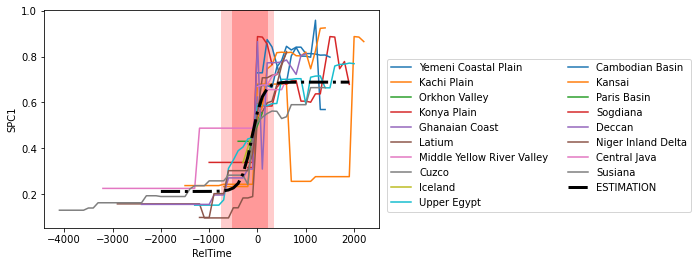

In [61]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)

plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped_no_Legend.pdf",dpi = 200, bbox_inches='tight')
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped",dpi = 200, bbox_inches='tight')
plt.savefig("SPC1_Time_Interval_Cutouts_Bootstrapped.pdf",dpi = 200, bbox_inches='tight')
plt.show()

In [57]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")

In [58]:
Cutout_DF[Cutout_DF["NGA"] == "Yemeni Coastal Plain"]


,NGA,RelTime,SPC1
413,Yemeni Coastal Plain,0,0.729010
414,Yemeni Coastal Plain,100,0.729010
415,Yemeni Coastal Plain,200,0.874002
416,Yemeni Coastal Plain,300,0.841906
417,Yemeni Coastal Plain,500,0.686559
418,Yemeni Coastal Plain,600,0.686559
419,Yemeni Coastal Plain,700,0.802861
420,Yemeni Coastal Plain,800,0.839822
421,Yemeni Coastal Plain,900,0.801720
422,Yemeni Coastal Plain,1000,0.801720


Cambodian Basin
166       0
167     100
168     200
169     300
170     400
171     500
172     600
173     700
174     800
175     900
176    1000
177    1100
178    1200
179    1300
180    1400
181    1500
Name: RelTime, dtype: object
Central Java
519      0
520    100
521    200
522    300
523    400
Name: RelTime, dtype: object
Cuzco
483      0
484    100
Name: RelTime, dtype: object
Deccan
427    -2400
428    -2300
429    -2200
430    -2100
431    -2000
432    -1900
433    -1800
434    -1700
435    -1600
436    -1500
437    -1400
438    -1300
439    -1200
440    -1100
441    -1000
442     -900
443     -800
444     -700
445     -600
446     -500
447     -400
448     -300
449     -200
450     -100
451        0
452      100
453      200
454      300
455      400
456      500
457      600
458      800
459      900
460     1000
Name: RelTime, dtype: object
Ghanaian Coast
351    -200
352    -100
353       0
Name: RelTime, dtype: object
Iceland
354    -300
355    -200
356    -100
357    

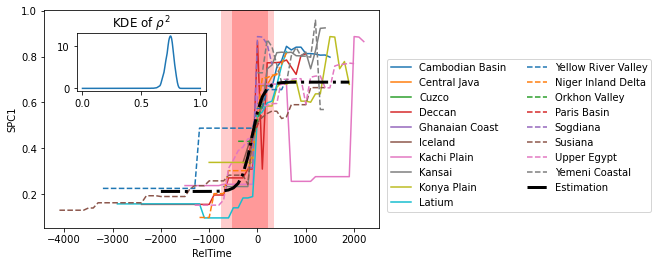

In [59]:
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])
style ="-"

for N in sorted(list(set(Cutout_DF["NGA"]))):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]

      # some abbreviations
    if N=="Middle Yellow River Valley":
        name = "Yellow River Valley"
    elif N == "Yemeni Coastal Plain":
        name = "Yemeni Coastal"
    else:
        name = N
        
    print(N)
    print(DF["RelTime"])
    ax1.plot(DF["RelTime"],   
             DF["SPC1"], style,label=name)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    if N == "Latium":
        style = "--"
    
ax1.plot(TimeRange, New_Fit, "-.",label="Estimation", c = "k", linewidth=3)
lgd = ax1.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
ax1.set_ylabel("SPC1")
ax1.set_xlabel("RelTime")
ax1.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
ax1.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
ax1.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

ax2.plot(np.arange(0.0,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.0,1,0.001)))
ax2.set_title(r'KDE of $\rho^2$')

plt.savefig("Cutout_Logistic_Times_Inset.pdf",bbox_extra_artists=(lgd,),dpi=300,bbox_inches='tight')
plt.show()

In [60]:
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)), 
      "years. The interval's start and end times are", np.round(T1_scaled), "and", np.round(T2_scaled),
      "The lower boundary's uncertainty is", np.round(T1_start_scaled), "and the upper boundary's uncertainty is", 
     np.round(T2_end_scaled), "years. Thus, the upper estimate for the time range is", np.round(T2_end_scaled-T1_start_scaled), "years.")

Most of the cultural evolution takes place in a time interval of  745.0 years. The interval's start and end times are -536.0 and 209.0 The lower boundary's uncertainty is -762.0 and the upper boundary's uncertainty is 340.0 years. Thus, the upper estimate for the time range is 1102.0 years.
